In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
pollen = pd.read_csv("pollen.csv", sep=";", parse_dates=["date"], na_values=[""])
pollen = pollen.set_index("date")
pollen["concentration"] = pollen["concentration"].interpolate(method="time")
pollen["concentration"] = pollen["concentration"].fillna(0)
pollen = pollen.reset_index()
pollen.head()

,date,concentration
0,2023-04-08,0.0
1,2023-04-09,0.0
2,2023-04-10,0.0
3,2023-04-11,1.0
4,2023-04-12,43.0


In [5]:
weather = pd.read_csv("moscow_weather_2017-2024.csv")
date = pd.to_datetime(weather['time'])
weather["year"] = date.dt.year
weather["month"] = date.dt.month
weather["day"] = date.dt.day
weather = weather.groupby(['year', 'month', 'day']).agg({"temperature": ["mean", "min", "max"],
                                                         "precipitation": "sum",
                                                         "humidity": "mean",
                                                         "wind_speed": "mean"}).reset_index()

weather.columns = [
    'year', 'month', 'day', 
    'temp_mean', 'temp_min', 'temp_max', 
    'precip_sum', 
    'humidity_mean', 
    'wind_speed_mean'
]
weather['date'] = pd.to_datetime(weather[['year', 'month', 'day']])
weather = weather.drop(['year', 'month', 'day'], axis=1)
weather = weather[['date', 'temp_mean', 'temp_min', 'temp_max', 'precip_sum', 'humidity_mean', 'wind_speed_mean']]
weather.head()

,date,temp_mean,temp_min,temp_max,precip_sum,humidity_mean,wind_speed_mean
0,2017-01-01,1.716667,1.2,2.2,0.5,94.625000,20.662500
1,2017-01-02,-0.175000,-5.2,1.9,1.9,93.500000,15.029167
2,2017-01-03,-7.750000,-13.5,-3.0,1.2,86.083333,10.775000
3,2017-01-04,-11.383333,-14.7,-6.9,1.5,86.250000,11.787500
4,2017-01-05,-11.245833,-18.6,-6.6,5.4,83.500000,19.670833


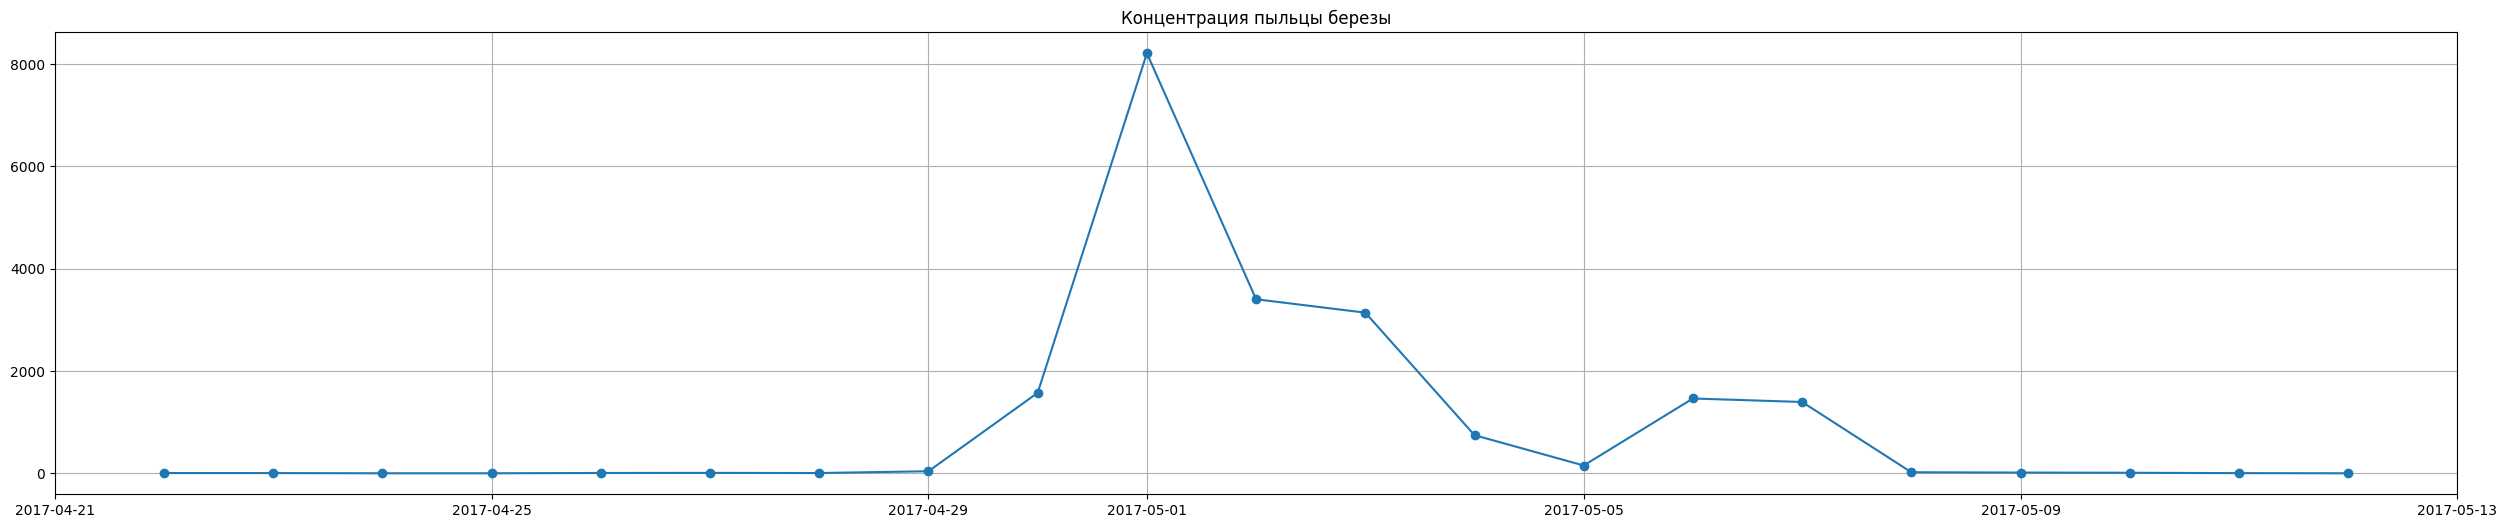

In [6]:
pollen2017 = pollen[pollen['date'] < pd.to_datetime('2018-01-01')]
plt.figure(figsize=(31,6))
plt.plot(pollen2017["date"], pollen2017["concentration"], marker="o")
plt.title("Концентрация пыльцы березы")
plt.grid(True)
plt.show()

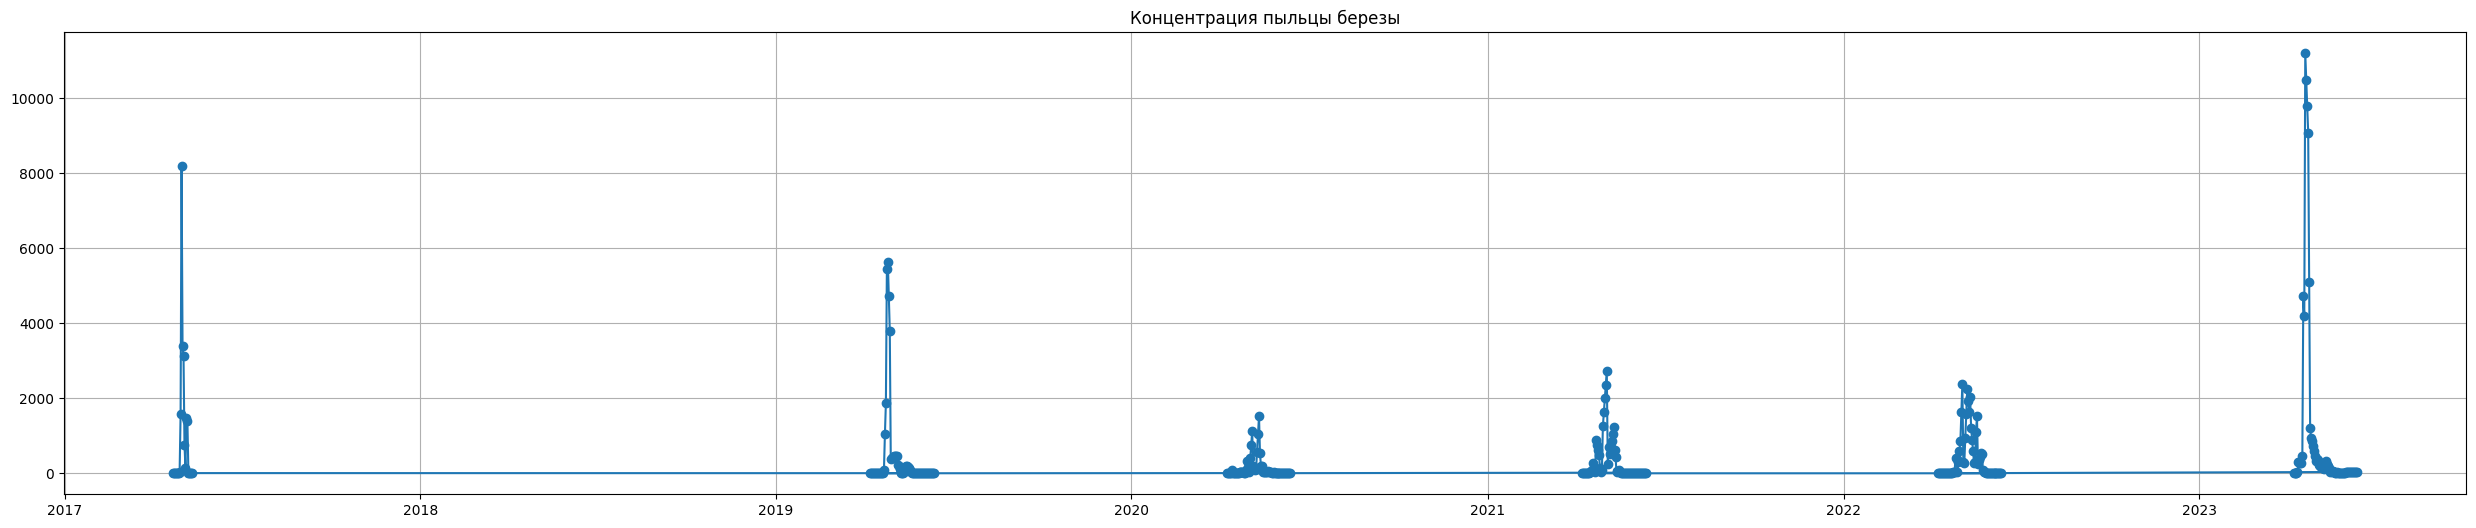

In [7]:
plt.figure(figsize=(31,6))
plt.plot(pollen["date"], pollen["concentration"], marker="o")
plt.title("Концентрация пыльцы березы")
plt.grid(True)
plt.show()

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

In [17]:
class Utils:
    def draw_plot(y_test, y_pred):
        plt.figure(figsize=(12, 6))
        plt.plot(y_test.index, y_test, label="Реальные значения", marker="o")
        plt.plot(y_test.index, y_pred, label="Прогноз", linestyle="--", marker="x")
        plt.title("Прогноз концентрации пыльцы (2022 год)")
        plt.xlabel("Дата")
        plt.ylabel("Концентрация")
        plt.legend()
        plt.grid(True)
        plt.show()
    
    def print_stats(y_test, y_pred):
        print("MAE:", mean_absolute_error(y_test, y_pred))
        print("R²:", r2_score(y_test, y_pred))
        print("RMSE:", root_mean_squared_error(y_test, y_pred))
        print("MSE:", mean_squared_error(y_test, y_pred))

# Линейная регрессия

In [18]:
pollen = pollen.set_index("date")
weather = weather.set_index("date")

KeyError: "None of ['date'] are in the columns"

In [19]:
merged_data = weather.join(pollen, how="left")
merged_data = merged_data.fillna(0)

In [ ]:
# merged_data.to_csv("weather_and_pollen.csv")

In [20]:
# features = ["temp_mean", "temp_min", "temp_max", "precip_sum", "humidity_mean", "wind_speed_mean"]
features = ["temp_mean", "precip_sum", "humidity_mean", "wind_speed_mean"]
target = "concentration"

In [21]:
test = merged_data[
    (merged_data.index.year == 2022) &
    (merged_data.index.month >= 4) &
    (merged_data.index.month <= 6)
    ]

train = merged_data[
    (merged_data.index.year != 2018) &
    (merged_data.index.year != 2022) &
    (merged_data.index.month >= 4) &
    (merged_data.index.month <= 6)
]

X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

In [22]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train_scaled, y_train)

LinearRegression()

In [23]:
y_pred = model.predict(X_test_scaled)

Utils.print_stats(y_test, y_pred)

MAE: 378.4652335570924
R²: -0.02285724263389688
RMSE: 569.4112746546292
MSE: 324229.19970380963


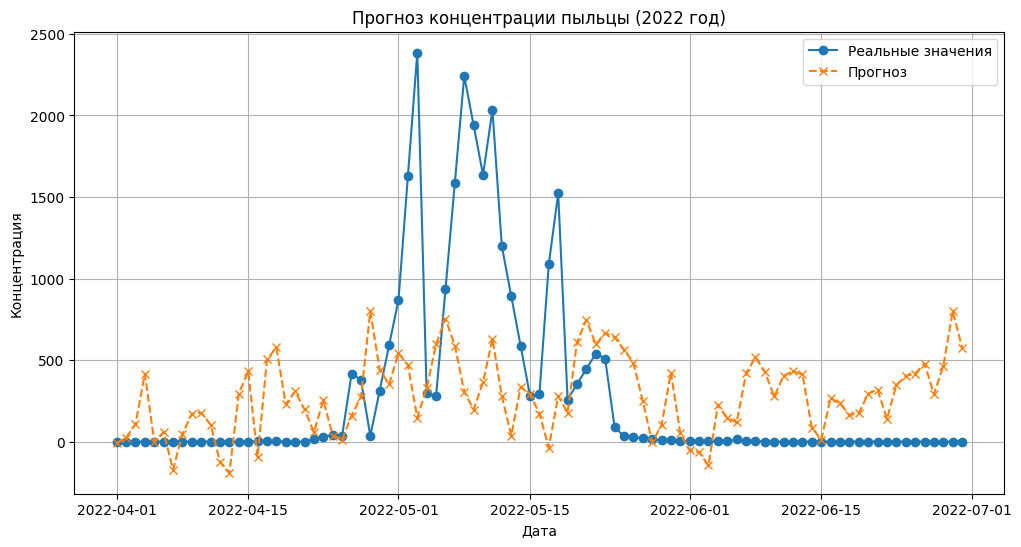

In [84]:
Utils.draw_plot(y_test, y_pred)

MAE: 5993.59112265853
R²: -113.5775293254119
RMSE: 6026.543232826484


d:\J\ed\my_env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


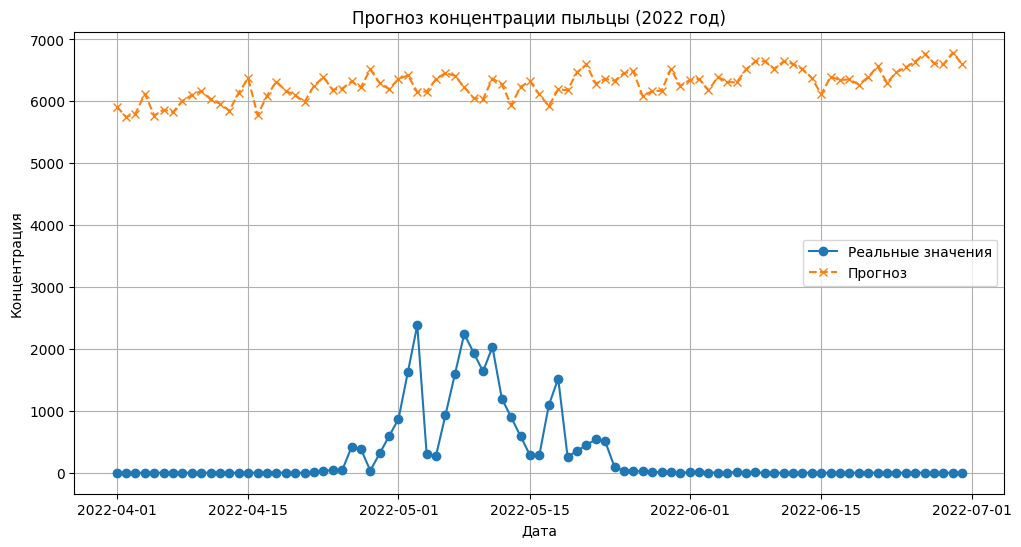

In [22]:
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

# poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)

# X_poly = poly.fit_transform(X_train[features])
# X_scaled = scaler.fit_transform(X_train[features])
# X_poly = poly.fit_transform(X_train_scaled)

# model_poly = LinearRegression()
model_poly = make_pipeline(
    StandardScaler(),  # Масштабирование данных
    PolynomialFeatures(degree=2, include_bias=False),  # Полином 2-й степени
    Ridge(alpha=0.5)  # Регуляризация для борьбы с переобучением
)

model_poly.fit(X_train, y_train)

y_pred_poly = model_poly.predict(X_test_scaled)

Utils.print_stats(y_test, y_pred_poly)
Utils.draw_plot(y_test, y_pred_poly)

In [24]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

In [24]:
def check_stationarity(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]:.3f}")
    print(f"p-value: {result[1]:.3f}")

print("Проверка стационарности исходного ряда:")
check_stationarity(y_train)

Проверка стационарности исходного ряда:
ADF Statistic: -6.356
p-value: 0.000


In [ ]:
SEASONAL_PERIOD = 365
model_sarimo = SARIMAX(
    endog=y_train,
    exog=X_train,  # Используем все экзогенные переменные
    order=(6, 0, 7),           # (p, d, q)
    seasonal_order=(1, 1, 1, SEASONAL_PERIOD), # (P, D, Q, S=7 дней)
    trend='c'
)
# model_sarimo = ARIMA(y_train, order=(1, 0, 1))

results = model_sarimo.fit(disp=False)
print(results.summary())


results.plot_diagnostics(figsize=(15, 12))
plt.show()


# forecast = results.get_forecast(
#     steps=len(y_test),
#     exog=X_test  # Важно: экзогенные переменные для прогнозного периода
# )
forecast_steps = len(X_test)
forecast = results.get_forecast(
    steps=forecast_steps,
    exog=X_test[['temp_mean', 'precip_sum']] # Те же экзогенные переменные
)

# y_pred_sarima = model_sarimo.predict(X_test_scaled)
# ci = forecast.conf_int()

# Utils.print_stats(y_test, y_pred_sarima)
# Utils.draw_plot(y_test, y_pred_sarima)

In [ ]:
SEASONAL_PERIOD = 30
model_sarimo = SARIMAX(
    endog=y_train,
    exog=X_train_scaled,  # Используем все экзогенные переменные
    order=(2, 0, 3),           # (p, d, q)
    seasonal_order=(1, 0, 1, SEASONAL_PERIOD), # (P, D, Q, S=7 дней)
    trend='c'
)

results = model_sarimo.fit(disp=False)
print(results.summary())


results.plot_diagnostics(figsize=(15, 12))
plt.show()


forecast_steps = len(X_test)
forecast_sarimo = results.get_forecast(
    steps=forecast_steps,
    exog=X_test_scaled # Те же экзогенные переменные
)


In [26]:
import matplotlib.dates as mdates
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
# 1. Рассчет метрик
mae = mean_absolute_error(y_test, forecast_sarimo.predicted_mean)
rmse = np.sqrt(mean_squared_error(y_test, forecast_sarimo.predicted_mean))
r2 = r2_score(y_test, forecast_sarimo.predicted_mean)

# 2. Создание фигуры
plt.figure(figsize=(14, 7))

# 3. Построение данных
# plt.plot(y_train.index, y_train, label='Исторические данные', color='blue', alpha=0.7)
plt.plot(y_test.index, y_test, label='Реальные значения', color='green', marker='o', markersize=4)
plt.plot(y_test.index, forecast_sarimo.predicted_mean, label='Прогноз', color='red', linestyle='--')

# 4. Доверительные интервалы
# plt.fill_between(
#     y_test.index,
#     forecast_sarimo.conf_int().iloc[:, 0],
#     forecast_sarimo.conf_int().iloc[:, 1],
#     color='gray',
#     alpha=0.2,
#     label='95% Доверительный интервал'
# )

# 5. Настройки графика
plt.title(f'Прогноз концентрации пыльцы (2022 год)\nMAE: {mae:.1f}, RMSE: {rmse:.1f}, R²: {r2:.2f}', fontsize=14)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Концентрация пыльцы', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# 6. Форматирование дат
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gcf().autofmt_xdate()

# 7. Выделение сезона пыления
# Укажите месяцы активного пыления (например, апрель-май)
# for month in [4, 5]:
#     plt.axvspan(
#         pd.Timestamp(f'2022-{month}-01'),
#         pd.Timestamp(f'2022-{month+1}-01') - pd.Timedelta(days=1),
#         color='yellow',
#         alpha=0.1,
#         label='Сезон пыления' if month == 4 else ''
#     )

# 8. Легенда и отображение
plt.legend(loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()

# 9. Дополнительная диагностика
print("\nОшибки прогноза:")
print(f"Средняя абсолютная ошибка (MAE): {mae:.1f}")
print(f"Корень из среднеквадратичной ошибки (RMSE): {rmse:.1f}")
print(f"Доля объясненной дисперсии (R²): {r2:.2f}")

In [ ]:
plot_acf(y_train, lags=30)
plot_pacf(y_train, lags=30)
plt.show()

In [ ]:
from pmdarima import auto_arima
y_train_auto = y_train.replace(0, 0.001)
model = auto_arima(
    y=y_train_auto,
    X=X_train_scaled,  # Экзогенные переменные
    seasonal=True,  # Включаем сезонность
    m=30,  # Базовая сезонность (7 дней). Если данные показывают годовую сезонность, измените на 365
    start_p=0,  # Минимальный порядок авторегрессии
    start_q=0,  # Минимальный порядок скользящего среднего
    max_p=3,    # Максимальный порядок авторегрессии
    max_q=3,    # Максимальный порядок скользящего среднего
    d=1,        # Порядок дифференцирования (auto_arima может подобрать автоматически, но лучше задать)
    D=1,        # Сезонный порядок дифференцирования
    trace=True,  # Вывод процесса подбора
    stepwise=True,  # Ускорение поиска
    suppress_warnings=True,
    error_action="ignore",
    n_fits=50   # Максимальное количество моделей для тестирования
)

forecast_sarimo_auto, conf_int = model.predict(
    n_periods=len(X_test_scaled),
    X=X_test_scaled,               # Экзогенные переменные для теста
    return_conf_int=True
)



MAE: 859.0
RMSE: 1336.6
R²: -4.64


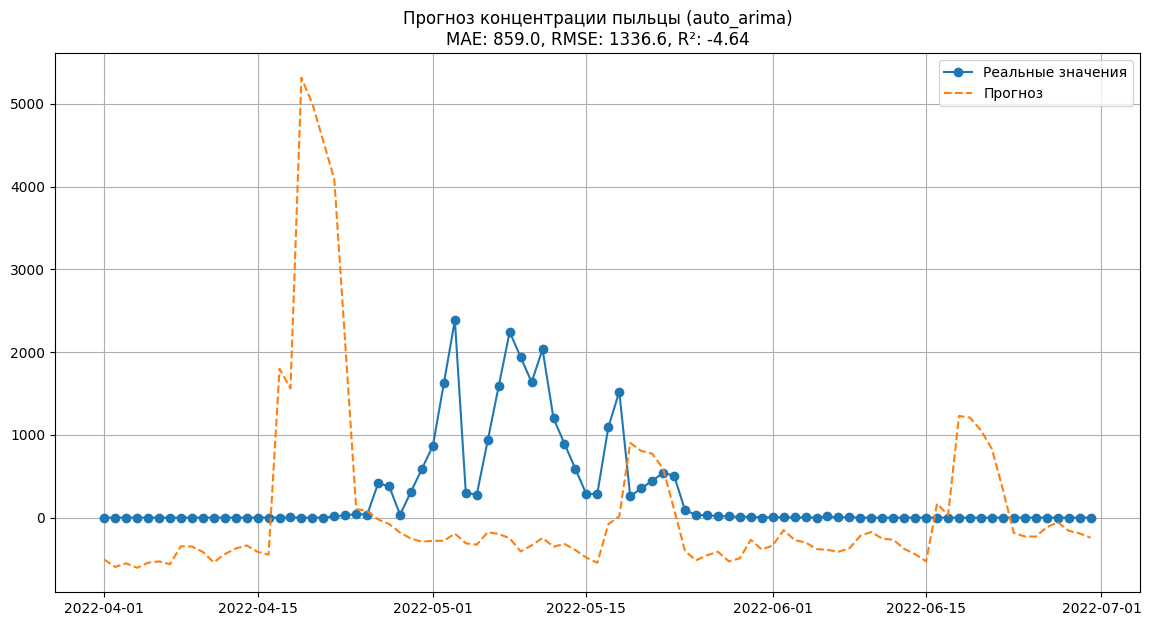

In [35]:
mae = mean_absolute_error(y_test, forecast_sarimo_auto)
rmse = np.sqrt(mean_squared_error(y_test, forecast_sarimo_auto))
r2 = r2_score(y_test, forecast_sarimo_auto)

print(f"\nMAE: {mae:.1f}")
print(f"RMSE: {rmse:.1f}")
print(f"R²: {r2:.2f}")

# 7. Визуализация
plt.figure(figsize=(14, 7))
plt.plot(test.index, y_test, label="Реальные значения", marker="o")
# plt.plot(y_test.index, forecast.predicted_mean, label='Прогноз', color='red', linestyle='--')
plt.plot(test.index, forecast_sarimo_auto, label="Прогноз", linestyle="--")
# plt.fill_between(test.index, conf_int[:,0], conf_int[:,1], alpha=0.1, color="gray")
plt.title(f"Прогноз концентрации пыльцы (auto_arima)\nMAE: {mae:.1f}, RMSE: {rmse:.1f}, R²: {r2:.2f}")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
print(y_train.describe())
plt.figure(figsize=(12, 4))
plt.plot(y_train)
plt.title("Концентрация пыльцы (трейновые данные)")
plt.show()

In [27]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
y_train_log = np.log1p(y_train)
# Шаг 1: SARIMA для сезонности
arima = ARIMA(y_train_log, order=(1,0,1)).fit()
seasonal = arima.predict()

# Шаг 2: GBRT для остатков
residuals = y_train - seasonal
gbr = GradientBoostingRegressor().fit(X_train, residuals)
forecast_sarimo_gbr = gbr.predict(X_test)

mae = mean_absolute_error(y_test, forecast_sarimo_gbr)
rmse = np.sqrt(mean_squared_error(y_test, forecast_sarimo_gbr))
r2 = r2_score(y_test, forecast_sarimo_gbr)

print(f"\nMAE: {mae:.1f}")
print(f"RMSE: {rmse:.1f}")
print(f"R²: {r2:.2f}")

# 7. Визуализация
plt.figure(figsize=(14, 7))
plt.plot(test.index, y_test, label="Реальные значения", marker="o")
# plt.plot(y_test.index, forecast.predicted_mean, label='Прогноз', color='red', linestyle='--')
plt.plot(test.index, forecast_sarimo_gbr, label="Прогноз", linestyle="--")
# plt.fill_between(test.index, conf_int[:,0], conf_int[:,1], alpha=0.1, color="gray")
plt.title(f"Прогноз концентрации пыльцы (gbr)\nMAE: {mae:.1f}, RMSE: {rmse:.1f}, R²: {r2:.2f}")
plt.legend()
plt.grid(True)
plt.show()

In [90]:
print("Доля нулей:", (y_train == 0).mean())

Доля нулей: 0.8571428571428571


In [93]:
Utils.print_stats(y_test, forecast_sarimo_gbr)

MAE: 129.21943822219626
R²: -1.5425530229783777
RMSE: 489.34694654524804


In [28]:
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit

xgboost_data = merged_data.copy()

for lag in [1, 2, 3, 7]:
    xgboost_data[f"pollen_lag_{lag}"] = xgboost_data["concentration"].shift(lag)
    xgboost_data[f"temp_mean_lag_{lag}"] = xgboost_data["temp_mean"].shift(lag)
    xgboost_data[f"temp_min_lag_{lag}"] = xgboost_data["temp_min"].shift(lag)
    xgboost_data[f"temp_max_lag_{lag}"] = xgboost_data["temp_max"].shift(lag)

xgboost_data['day_of_year'] = xgboost_data.index.dayofyear
xgboost_data['day_sin'] = np.sin(2 * np.pi * xgboost_data['day_of_year'] / 365)
xgboost_data['day_cos'] = np.cos(2 * np.pi * xgboost_data['day_of_year'] / 365)
xgboost_data['pollen_7d_avg'] = xgboost_data['concentration'].rolling(7).mean()
xgboost_data['pollen_7d_max'] = xgboost_data['concentration'].rolling(7).max()

# Удаление пропусков
xgboost_data = xgboost_data.dropna()

train_years = [2017, 2019, 2020, 2021, 2023]
test_year = 2022

train_mask = xgboost_data.index.year.isin(train_years)
test_mask = xgboost_data.index.year == test_year

# Разделение на признаки и целевую переменную
X = xgboost_data.drop("concentration", axis=1)
y = xgboost_data["concentration"]

X_train = xgboost_data[train_mask].drop("concentration", axis=1)
y_train = xgboost_data[train_mask]["concentration"]
X_test = xgboost_data[test_mask].drop("concentration", axis=1)
y_test = xgboost_data[test_mask]["concentration"]

weights = np.where(y_train == 0, 1, 3)

model = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    random_state=42
)
model.fit(X_train, y_train, sample_weight=weights)

# Прогноз и оценка
preds = model.predict(X_test)
print(f"MAE для 2022 года: {mean_absolute_error(y_test, preds)}")

# Дополнительно: важность признаков
feature_importances = pd.Series(model.feature_importances_, index=X_train.columns)
print("\nВажность признаков:")
print(feature_importances.sort_values(ascending=False))

# Временное разделение данных
# tscv = TimeSeriesSplit(n_splits=3)
# for train_index, test_index in tscv.split(X):
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
#     w_train, w_test = weights[train_index], weights[test_index]

#     # Обучение модели
#     model = xgb.XGBRegressor(n_estimators=300, learning_rate=0.05)
#     model.fit(X_train, y_train, sample_weight=w_train)
    
#     # Прогноз и оценка
#     preds = model.predict(X_test)
#     print(f"MAE: {mean_absolute_error(y_test, preds, sample_weight=w_test)}")

MAE для 2022 года: 46.151183138304496

Важность признаков:
pollen_lag_1       4.883650e-01
day_of_year        2.988168e-01
pollen_7d_max      4.668926e-02
temp_min_lag_3     4.172166e-02
temp_min           2.878240e-02
temp_mean          2.491133e-02
temp_max_lag_1     1.376979e-02
temp_min_lag_2     1.203149e-02
temp_min_lag_7     1.082030e-02
pollen_lag_7       7.244721e-03
pollen_lag_2       5.266278e-03
pollen_7d_avg      3.254369e-03
temp_min_lag_1     3.231005e-03
wind_speed_mean    2.307015e-03
humidity_mean      2.210995e-03
pollen_lag_3       2.087709e-03
temp_max           1.919090e-03
temp_mean_lag_1    1.703365e-03
precip_sum         1.634914e-03
temp_mean_lag_2    1.314051e-03
temp_max_lag_2     6.544798e-04
temp_max_lag_3     4.138227e-04
temp_mean_lag_3    3.237999e-04
temp_max_lag_7     2.797721e-04
temp_mean_lag_7    2.416365e-04
day_sin            4.504820e-06
day_cos            3.845551e-07
dtype: float32


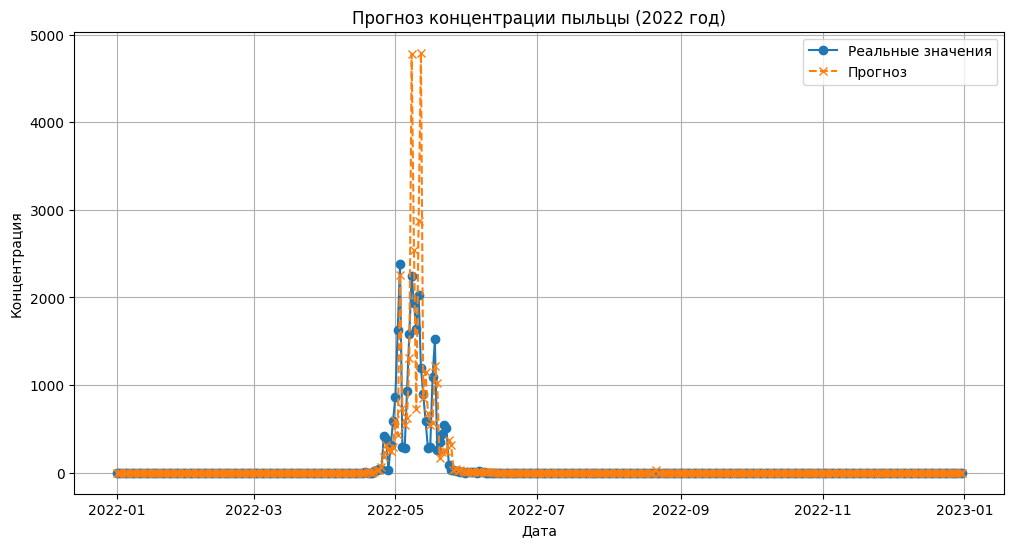

MAE: 46.151183138304496
R²: 0.2627264643599573
RMSE: 263.50945092358376
MSE: 69437.23072604858


In [29]:
Utils.draw_plot(y_test, preds)
Utils.print_stats(y_test, preds)
# plt.figure(figsize=(31,6))
# plt.plot(y_test.index, y_test, marker="o")
# plt.title("Концентрация пыльцы березы")
# plt.grid(True)
# plt.show()

In [ ]:
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV

xgboost_data = merged_data.copy()

for lag in [1, 2, 3, 7]:
    xgboost_data[f"pollen_lag_{lag}"] = xgboost_data["concentration"].shift(lag)
    xgboost_data[f"temp_mean_lag_{lag}"] = xgboost_data["temp_mean"].shift(lag)
    xgboost_data[f"temp_min_lag_{lag}"] = xgboost_data["temp_min"].shift(lag)
    xgboost_data[f"temp_max_lag_{lag}"] = xgboost_data["temp_max"].shift(lag)

xgboost_data['day_of_year'] = xgboost_data.index.dayofyear
xgboost_data['day_sin'] = np.sin(2 * np.pi * xgboost_data['day_of_year'] / 365)
xgboost_data['day_cos'] = np.cos(2 * np.pi * xgboost_data['day_of_year'] / 365)
xgboost_data['pollen_7d_avg'] = xgboost_data['concentration'].rolling(7).mean()
xgboost_data['pollen_7d_max'] = xgboost_data['concentration'].rolling(7).max()

# Удаление пропусков
xgboost_data = xgboost_data.dropna()

train_years = [2017, 2019, 2020, 2021, 2023]
test_year = 2022

train_mask = xgboost_data.index.year.isin(train_years)
test_mask = xgboost_data.index.year == test_year

# Разделение на признаки и целевую переменную
X = xgboost_data.drop("concentration", axis=1)
y = xgboost_data["concentration"]

X_train = xgboost_data[train_mask].drop("concentration", axis=1)
y_train = xgboost_data[train_mask]["concentration"]
X_test = xgboost_data[test_mask].drop("concentration", axis=1)
y_test = xgboost_data[test_mask]["concentration"]

MAE для 2022 года: 29.923937696703607

Важность признаков:
pollen_lag_1       0.398672
pollen_7d_max      0.169359
day_of_year        0.121085
pollen_lag_7       0.060493
temp_max           0.046436
temp_min_lag_3     0.034201
temp_min_lag_7     0.026928
temp_mean          0.024401
precip_sum         0.016563
temp_max_lag_3     0.014890
temp_mean_lag_1    0.011934
day_sin            0.011855
humidity_mean      0.010991
pollen_lag_2       0.007152
pollen_7d_avg      0.006987
wind_speed_mean    0.006555
pollen_lag_3       0.005146
temp_min_lag_1     0.004626
temp_min           0.004437
temp_min_lag_2     0.003869
temp_mean_lag_3    0.002858
temp_max_lag_1     0.002268
temp_mean_lag_7    0.002165
temp_mean_lag_2    0.002137
temp_max_lag_2     0.002004
temp_max_lag_7     0.001972
day_cos            0.000016
dtype: float32


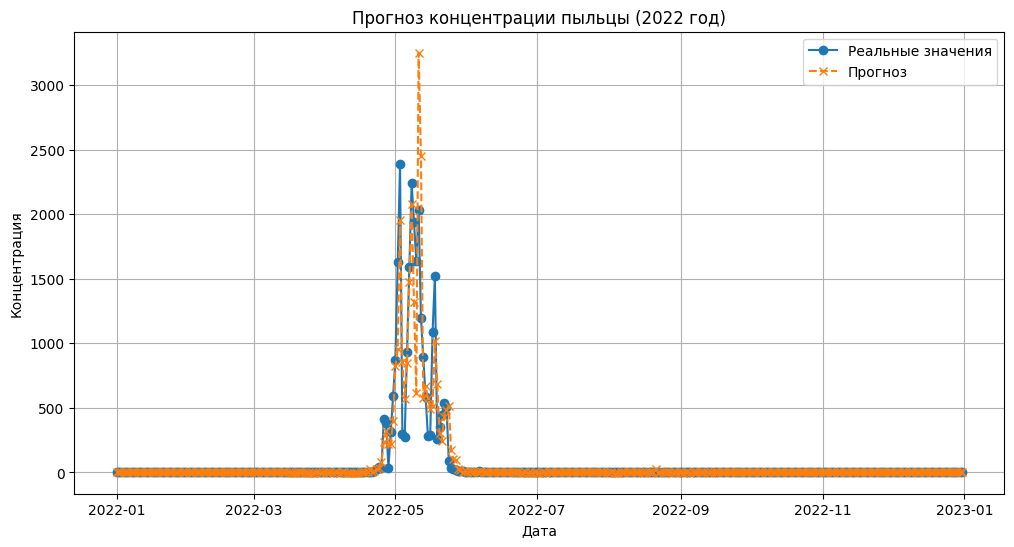

MAE: 29.923937696703607
R²: 0.7981260733739985
RMSE: 137.88657643613487
MSE: 19012.707961278065


In [31]:
weights = np.where(y_train == 0, 1, 3)

model = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    random_state=42
)
# model.fit(X_train, y_train, sample_weight=weights)

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 1, 10]
}

search = RandomizedSearchCV(model, param_grid, n_iter=50, cv=3, scoring='neg_mean_absolute_error')
search.fit(X_train, y_train, sample_weight=weights)
best_model = search.best_estimator_

# Прогноз и оценка
preds = best_model.predict(X_test)
print(f"MAE для 2022 года: {mean_absolute_error(y_test, preds)}")

# Дополнительно: важность признаков
feature_importances = pd.Series(best_model.feature_importances_, index=X_train.columns)
print("\nВажность признаков:")
print(feature_importances.sort_values(ascending=False))

Utils.draw_plot(y_test, preds)
Utils.print_stats(y_test, preds)

In [147]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Bidirectional, Attention, Concatenate

lstm_data = merged_data.copy()

for lag in [1, 2, 3, 7]:
    lstm_data[f"pollen_lag_{lag}"] = lstm_data["concentration"].shift(lag)
    lstm_data[f"temp_diff_{lag}"] = lstm_data["temp_mean"].diff(lag)

lstm_data['day_cos'] = np.cos(2 * np.pi * lstm_data.index.dayofyear / 365)
lstm_data['week_cos'] = np.cos(2 * np.pi * lstm_data.index.isocalendar().week / 52)

lstm_data['temp_humidity'] = lstm_data['temp_mean'] * lstm_data['humidity_mean']

# Сезонные маркеры
lstm_data['is_peak'] = (lstm_data.index.month == 5) & (lstm_data.index.day >= 15)
lstm_data = lstm_data.drop(columns=['temp_diff_1', 'temp_diff_7']) 
lstm_data['temp_7d_avg'] = lstm_data['temp_mean'].rolling(7).mean()
lstm_data['humidity_lag3'] = lstm_data['humidity_mean'].shift(3)
lstm_data['precip_lag2'] = lstm_data['precip_sum'].shift(2)
lstm_data['pollen_3d_ma'] = lstm_data['concentration'].rolling(3).mean()

# Удаление пропусков
lstm_data = lstm_data.dropna()
lstm_data = lstm_data[
    (lstm_data.index.month >= 4) &
    (lstm_data.index.month <= 6)
    ]

train_mask = lstm_data.index.year.isin([2017, 2019, 2020, 2021, 2023])
test_mask = lstm_data.index.year == 2022

X_train = lstm_data[train_mask].drop("concentration", axis=1)
y_train = lstm_data[train_mask]["concentration"]
X_test = lstm_data[test_mask].drop("concentration", axis=1)
y_test = lstm_data[test_mask]["concentration"]

feature_scaler = RobustScaler()
target_scaler = RobustScaler()

X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)

y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))

In [146]:
def augment_sequences(X, y, n_steps, noise_level=0.02):
    X_aug, y_aug = [], []
    for i in range(len(X)):
        # Исходные данные
        X_aug.append(X[i])
        y_aug.append(y[i])
        
        # Аугментация: добавление шума
        X_noisy = X[i] + np.random.normal(0, noise_level, X[i].shape)
        X_aug.append(X_noisy)
        y_aug.append(y[i])
        
        # Аугментация: временной сдвиг
        if i > 0:
            X_shifted = np.roll(X[i], shift=1, axis=0)
            X_aug.append(X_shifted)
            y_aug.append(y[i])
    return np.array(X_aug), np.array(y_aug)

def create_sequences(data, target, n_steps):
    X, y = [], []
    for i in range(len(data)-n_steps):
        X.append(data[i:i+n_steps])
        y.append(target[i+n_steps])
    return np.array(X), np.array(y)

# Параметры временного окна
n_steps = 10  # использовать 7 дней истории для предсказания
# n_features = scaled_train.shape[1]

# Создание последовательностей
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, n_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, n_steps)

X_train_aug, y_train_aug = augment_sequences(X_train_seq, y_train_seq, n_steps)

# Построение модели LSTM
model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True)),
    Attention(),  # Добавить механизм внимания
    LSTM(64, recurrent_dropout=0.2),
    Dense(128, activation='swish'),
    Dropout(0.3),
    Dense(1)
])

def lr_scheduler(epoch, lr):
    warmup_epochs = 10
    if epoch < warmup_epochs:
        return 0.001 * (epoch + 1)/warmup_epochs
    return 0.001 * np.exp(-0.01*(epoch - warmup_epochs))

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

sample_weights = np.where(y_train_aug.flatten() == 0, 2, 4)

history = model.fit(
    X_train_aug,
    y_train_aug,
    epochs=100,
    batch_size=16,  # Уменьшил размер батча
    validation_split=0.2,
    callbacks=[
        EarlyStopping(patience=10, restore_best_weights=True),
        LearningRateScheduler(lr_scheduler, verbose=1)
    ],
    sample_weight=sample_weights,
    verbose=1
)

# Прогнозирование и обратное преобразование данных
preds_scaled = model.predict(X_test_seq)
preds = target_scaler.inverse_transform(preds_scaled).flatten()

window_size = 1
preds_smoothed = pd.Series(preds).rolling(window_size, center=True, min_periods=1).mean().values

# Обратное преобразование y_test
y_true = y_test.values[n_steps:]

plt.figure(figsize=(31,6))
plt.plot(X_test.index[n_steps:], y_true, label='Real', marker='o', linestyle='--', markersize=5)
plt.plot(X_test.index[n_steps:], preds_smoothed, label='Predicted', marker='o', markersize=5)
plt.title("Концентрация пыльцы березы")
plt.grid(True)
plt.show()
Utils.print_stats(y_true, preds_smoothed)


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/100


ValueError: Attention layer must be called on a list of inputs, namely [query, value] or [query, value, key]. Received: inputs=(None, 10, 256).

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 4752.1260 - mae: 7.4785 - val_loss: 6783.4946 - val_mae: 9.2435 - learning_rate: 1.0000e-04
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 5773.2993 - mae: 8.3999 - val_loss: 6484.8198 - val_mae: 9.7346 - learning_rate: 2.0000e-04
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 5661.6660 - mae: 10.0682 - val_loss: 6078.9268 - val_mae: 9.5964 - learning_rate: 3.0000e-04
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 4665.8999 - mae: 8.5742 - val_loss: 5603.1855 - val_mae: 9.2910 - learning_rate: 4.0000e-04
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 3248.0432 - mae: 7.4376 - val_loss: 4990.6484 - val_mae: 8.8909 - learning_rate: 5.0000e-04
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 4177.2842 - mae: 8.0131 - val_loss: 4646.1606 - val_mae: 8.7068 - learning_rate: 6.0000e-04
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 4353.5479 - mae: 8.0944 - v

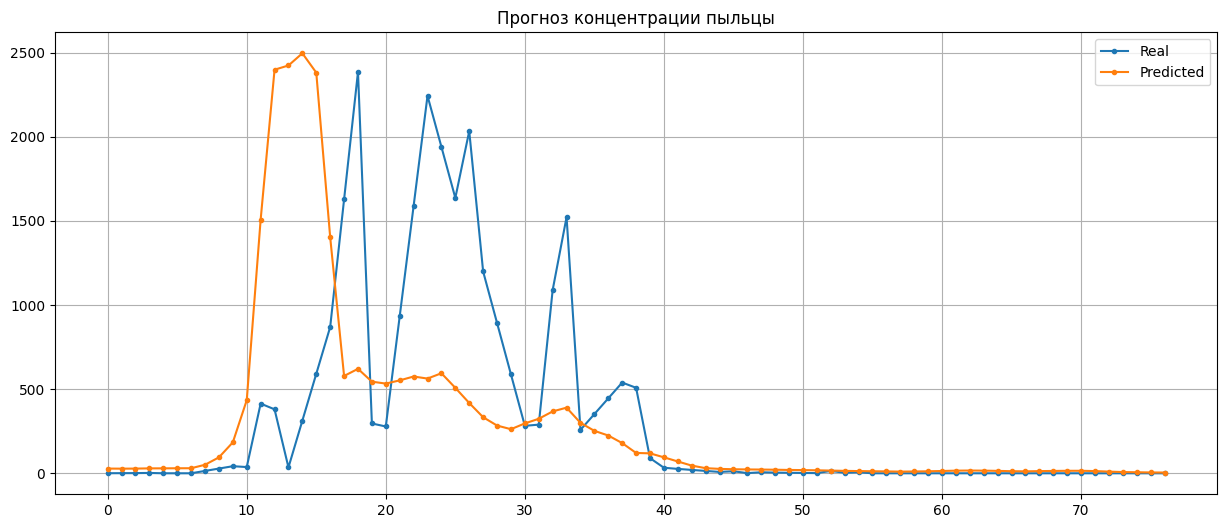

MAE: 347.1
R²: -0.34
RMSE: 691.5


In [148]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Dropout, MultiHeadAttention, LayerNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Загрузка и подготовка данных (предполагаем, что merged_data уже существует)
lstm_data = merged_data.copy()

# Создание временных фичей
for lag in [1, 2, 3, 7]:
    lstm_data[f"pollen_lag_{lag}"] = lstm_data["concentration"].shift(lag)
    lstm_data[f"temp_diff_{lag}"] = lstm_data["temp_mean"].diff(lag)

lstm_data['day_cos'] = np.cos(2 * np.pi * lstm_data.index.dayofyear / 365)
lstm_data['is_peak'] = (lstm_data.index.month == 5) & (lstm_data.index.day >= 15)

# Дополнительные фичи
lstm_data['temp_7d_avg'] = lstm_data['temp_mean'].rolling(7).mean()
lstm_data = lstm_data.drop(columns=['temp_diff_1', 'temp_diff_7']).dropna()

# Фильтрация по месяцам
lstm_data = lstm_data[(lstm_data.index.month >= 4) & (lstm_data.index.month <= 6)]

# Разделение на train/test
train_mask = lstm_data.index.year.isin([2017, 2019, 2020, 2021, 2023])
test_mask = lstm_data.index.year == 2022

X_train = lstm_data[train_mask].drop("concentration", axis=1)
y_train = lstm_data[train_mask]["concentration"]
X_test = lstm_data[test_mask].drop("concentration", axis=1)
y_test = lstm_data[test_mask]["concentration"]

# Масштабирование
feature_scaler = RobustScaler()
target_scaler = RobustScaler()

X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))

# Создание последовательностей
def create_sequences(data, target, n_steps):
    X, y = [], []
    for i in range(len(data)-n_steps):
        X.append(data[i:i+n_steps])
        y.append(target[i+n_steps])
    return np.array(X), np.array(y)

n_steps = 14
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, n_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, n_steps)

# Аугментация данных
def augment_sequences(X, y, noise_level=0.03):
    X_noisy = X + np.random.normal(0, noise_level, X.shape)
    X_shifted = np.roll(X, shift=1, axis=1)
    return np.vstack([X, X_noisy, X_shifted]), np.vstack([y, y, y])

X_train_aug, y_train_aug = augment_sequences(X_train_seq, y_train_seq)

# Построение модели с Attention
def build_model(input_shape):
    inputs = Input(shape=input_shape)
    
    # Bidirectional LSTM
    x = Bidirectional(LSTM(128, return_sequences=True))(inputs)
    x = LayerNormalization()(x)
    
    # Multi-Head Attention
    attn_output = MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
    x = LayerNormalization()(attn_output + x)  # Residual connection
    
    # Final LSTM
    x = LSTM(64, recurrent_dropout=0.2)(x)
    x = Dense(128, activation='swish', kernel_regularizer=regularizers.L1L2(0.001))(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1)(x)
    
    return Model(inputs=inputs, outputs=outputs)

model = build_model((n_steps, X_train_seq.shape[2]))

# Настройка обучения
def lr_scheduler(epoch, lr):
    warmup = 10
    if epoch < warmup:
        return 0.001 * (epoch+1)/warmup
    return 0.001 * 0.95**(epoch - warmup)

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='mse',
    metrics=['mae']
)

# Веса для семплов
sample_weights = np.interp(y_train_aug.flatten(), 
                          [0, np.percentile(y_train_aug, 95)], 
                          [1, 5])

# Обучение
history = model.fit(
    X_train_aug,
    y_train_aug,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[
        EarlyStopping(patience=15, restore_best_weights=True),
        LearningRateScheduler(lr_scheduler)
    ],
    sample_weight=sample_weights,
    verbose=1
)

# Прогнозирование и оценка
preds_scaled = model.predict(X_test_seq)
preds = target_scaler.inverse_transform(preds_scaled).flatten()

# Сглаживание предсказаний
window_size = 5
preds_smoothed = pd.Series(preds).rolling(window_size, center=True, min_periods=1).mean().values
y_true = y_test.values[n_steps:]

# Визуализация
plt.figure(figsize=(15, 6))
plt.plot(y_true, label='Real', marker='o', ms=3)
plt.plot(preds_smoothed, label='Predicted', marker='o', ms=3)
plt.title('Прогноз концентрации пыльцы')
plt.legend()
plt.grid()
plt.show()

# Метрики
def print_metrics(y_true, y_pred):
    print(f'MAE: {mean_absolute_error(y_true, y_pred):.1f}')
    print(f'R²: {r2_score(y_true, y_pred):.2f}')
    print(f'RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.1f}')

print_metrics(y_true, preds_smoothed)

In [150]:
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, f1_score, confusion_matrix

C:\Users\79648\AppData\Local\Temp\ipykernel_8068\3245965926.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['predicted_season'] = clf.predict(test_data[classifier_features])


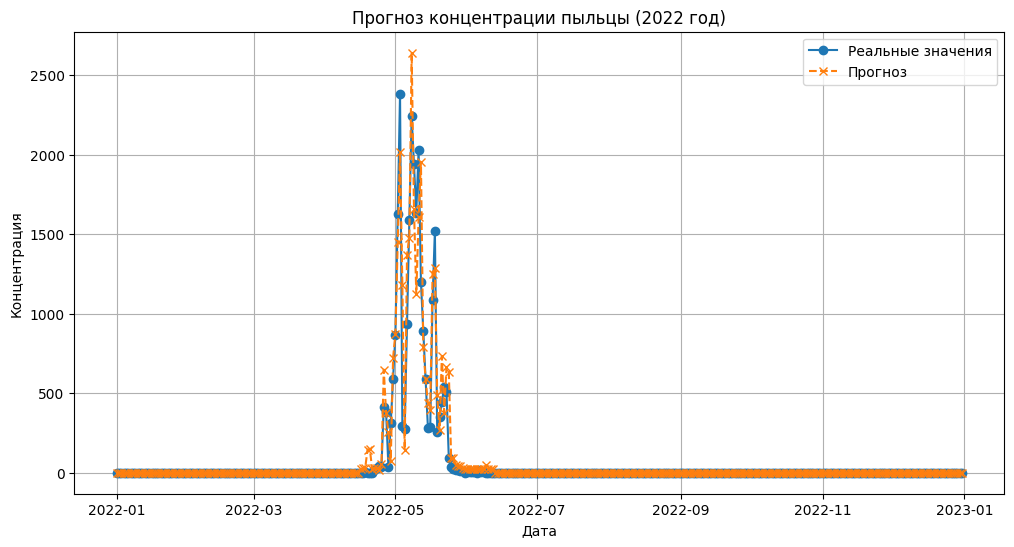

MAE: 23.3323435113424
R²: 0.9047238071868771
RMSE: 94.7270626716829
MSE: 8973.21640240494


In [158]:
hybrid_data = merged_data.copy()

# Создание фичей для классификатора
hybrid_data['day_of_year'] = hybrid_data.index.dayofyear
hybrid_data['temp_5d_avg'] = hybrid_data['temp_mean'].rolling(5).mean()
hybrid_data['warming_flag'] = (hybrid_data['temp_mean'].rolling(3).min() > 12).astype(int)

# Создание целевой переменной для классификации
hybrid_data['is_season'] = (hybrid_data['concentration'] > 0).astype(int)

for lag in [1, 2, 3, 7]:
    hybrid_data[f"pollen_lag_{lag}"] = hybrid_data["concentration"].shift(lag)
    hybrid_data[f"temp_mean_lag_{lag}"] = hybrid_data["temp_mean"].shift(lag)
    hybrid_data[f"precip_lag_{lag}"] = hybrid_data["precip_sum"].shift(lag)
    hybrid_data[f"temp_min_lag_{lag}"] = hybrid_data["temp_min"].shift(lag)
    hybrid_data[f"temp_max_lag_{lag}"] = hybrid_data["temp_max"].shift(lag)

hybrid_data['pollen_7d_max'] = hybrid_data['concentration'].rolling(7).max()

hybrid_data['days_in_season'] = hybrid_data.groupby(
    (hybrid_data['is_season'] == 0).cumsum()
).cumcount()

# Удаление пропусков
hybrid_data = hybrid_data.dropna()

# Разделение данных
train_mask = hybrid_data.index.year.isin([2017, 2019, 2020, 2021, 2023])
test_mask = hybrid_data.index.year == 2022

# Классификационные фичи
classifier_features = [
    'day_of_year', 
    'temp_5d_avg',
    'warming_flag',
    'temp_min',
    'temp_max'
]

hybrid_data['humidity_3d_avg'] = hybrid_data['humidity_mean'].rolling(3).mean()
hybrid_data['precip_3d_sum'] = hybrid_data['precip_sum'].rolling(3).sum()
hybrid_data['temp_amplitude'] = hybrid_data['temp_max'] - hybrid_data['temp_min']
hybrid_data['season_progress'] = (hybrid_data['day_of_year'] - 100) / 60  # Нормировка 100-160 дней

classifier_features += [
    'humidity_3d_avg',
    'precip_3d_sum',
    'temp_amplitude',
    'season_progress'
]

# Регрессионные фичи
regression_features = [
    'temp_mean',
    'precip_sum',
    'humidity_mean',
    'pollen_lag_1',
    'pollen_lag_3',
    'days_in_season',
    'temp_mean_lag_3',
    'precip_lag_7',
    'temp_min_lag_1',
    'temp_min_lag_7',
    'temp_max_lag_1',
    'temp_max_lag_7',
    'pollen_7d_max'
]

hybrid_data['pollen_3d_trend'] = hybrid_data['concentration'].rolling(3).apply(
    lambda x: np.polyfit(range(3), x, 1)[0], raw=True
)

# Взаимодействие признаков
hybrid_data['temp_humidity'] = hybrid_data['temp_mean'] * hybrid_data['humidity_mean']

regression_features += [
    'pollen_3d_trend',
    'temp_humidity',
    'temp_amplitude'
]

# Обучение классификатора
clf = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=5,
    verbose=0
)

# Обучение только на сезонных месяцах (апрель-июнь)
season_mask = hybrid_data.index.month.isin([4,5,6])
clf.fit(
    hybrid_data.loc[train_mask & season_mask, classifier_features],
    hybrid_data.loc[train_mask & season_mask, 'is_season'],
    eval_set=(hybrid_data.loc[test_mask & season_mask, classifier_features],
              hybrid_data.loc[test_mask & season_mask, 'is_season']),
    early_stopping_rounds=50
)

reg_data = hybrid_data[hybrid_data['is_season'] == 1]

train_mask_reg = reg_data.index.year.isin([2017, 2019, 2020, 2021, 2023])

X_reg = reg_data.loc[train_mask_reg, regression_features]
y_reg = reg_data.loc[train_mask_reg, 'concentration']

# Настройка весов для регрессии
# weights_reg = np.where(y_reg < y_reg.quantile(0.9), 1, 3)
weights_reg = np.interp(y_reg, 
                      [0, y_reg.quantile(0.9), y_reg.max()], 
                      [1, 3, 5])

# Поиск гиперпараметров
model = xgb.XGBRegressor(objective='reg:squarederror')
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

search = RandomizedSearchCV(
    model, 
    param_grid, 
    n_iter=30, 
    cv=TimeSeriesSplit(n_splits=3),
    scoring='neg_mean_absolute_error'
)
search.fit(X_reg, y_reg, sample_weight=weights_reg)
best_reg = search.best_estimator_

# Прогнозирование
test_data = hybrid_data[test_mask]
test_data['predicted_season'] = clf.predict(test_data[classifier_features])

# Фильтрация тестовых данных для регрессии
X_test_reg = test_data[test_data['predicted_season'] == 1][regression_features]
y_test_reg = test_data[test_data['predicted_season'] == 1]['concentration']

# Предсказание концентрации
if len(X_test_reg) > 0:
    test_preds = best_reg.predict(X_test_reg)
    final_preds = pd.Series(test_preds, index=X_test_reg.index)
else:
    final_preds = pd.Series(0, index=test_data.index)

# Заполнение пропущенных дней нулями
full_preds = final_preds.reindex(test_data.index).fillna(0)

Utils.draw_plot(test_data['concentration'], full_preds)
Utils.print_stats(test_data['concentration'], full_preds)

In [ ]:
def predict_season(model_clf, model_reg, test_data, classifier_features, regression_features):
    # Создаем копию тестовых данных для прогнозирования
    forecast_df = test_data.copy()
    
    # Инициализируем колонку для прогнозов
    forecast_df['predicted'] = 0.0
    
    # Подготовка лагов - используем фактические данные для инициализации
    for lag in [1, 2, 3, 7]:
        forecast_df[f'predicted_lag_{lag}'] = forecast_df['concentration'].shift(lag)
    
    # Имитация пошагового прогноза
    for i in range(len(forecast_df)):
        current_date = forecast_df.index[i]
        
        # Формируем фичи для текущей даты
        current_features = forecast_df.iloc[[i]].copy()
        
        # Обновляем динамические признаки
        if i > 0:
            for lag in [1, 2, 3, 7]:
                if i >= lag:
                    current_features[f'predicted_lag_{lag}'] = forecast_df['predicted'].iloc[i-lag]
        
        # Прогноз классификатора
        is_season = model_clf.predict(current_features[classifier_features])[0]
        
        if is_season:
            # Подготовка фичей для регрессии
            reg_features = current_features[regression_features]
            
            # Замена лагов на предсказанные значения
            for lag in [1, 3, 7]:
                lag_col = f'pollen_lag_{lag}'
                if lag_col in reg_features.columns:
                    reg_features[lag_col] = current_features[f'predicted_lag_{lag}'].values[0]
            
            # Прогноз регрессора
            pred = model_reg.predict(reg_features)[0]
            forecast_df.loc[current_date, 'predicted'] = max(pred, 10)  # Минимальный порог
        
        # Обновление лагов для следующих итераций
        for lag in [1, 2, 3, 7]:
            if i >= lag:
                forecast_df.loc[forecast_df.index[i+1-lag], f'predicted_lag_{lag}'] = forecast_df.loc[current_date, 'predicted']
    
    # Постобработка
    forecast_df['predicted_smoothed'] = forecast_df['predicted'].rolling(
        window=3, center=True, min_periods=1
    ).mean()
    
    return forecast_df

# Получение прогноза для 2022 года
test_2022 = hybrid_data[test_mask].copy()
forecast_results = predict_season(clf, best_reg, test_2022, classifier_features, regression_features)

# Визуализация результатов
plt.figure(figsize=(15, 6))
plt.plot(forecast_results.index, forecast_results['concentration'], label='Факт', marker='o')
plt.plot(forecast_results.index, forecast_results['predicted_smoothed'], label='Прогноз', linestyle='--')
plt.title('Прогноз концентрации пыльцы на 2022 год')
plt.xlabel('Дата')
plt.ylabel('Концентрация пыльцы')
plt.legend()
plt.grid(True)
plt.show()

# Оценка точности
print("Метрики качества для всего сезона 2022:")
Utils.print_stats(forecast_results['concentration'], forecast_results['predicted_smoothed'])

print("\nМетрики для активных дней:")
active_days = forecast_results[forecast_results['is_season'] == 1]
Utils.print_stats(active_days['concentration'], active_days['predicted_smoothed'])